![Logo](https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/shared_assets/logo.png)

Made by **Domonkos Nagy**, **Balázs Nagy** and **Zoltán Barta**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/BartaZoltan/deep-reinforcement-learning-course/blob/main/notebooks/sessions/session_01_k_armed_bandit/session_01_k_armed_bandit.ipynb)

# $k$-armed Bandit

Consider the following learning problem. You are faced repeatedly with a choice among
$k$ different options, or actions. After each choice, you receive a numerical reward
from a stationary probability distribution that depends on the action you selected. Your
objective is to maximize the expected total reward over some time period, for example,
over 1000 action selections, or time steps.

This is called the $k$-armed bandit problem. You can visualize this problem as having to
choose between $k$ slot machines (also known as one-armed bandits) at each time step,
each of which has a different probability distribution for rewards - that is where the name comes from.

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/k_armed_bandit.png" width="500"/>

The $k$-armed bandit problem illustrates an important problem in reinforcement
learning: **exploration vs. exploitation**. At each time step $t$, the agent has to make a decision:
take the action with the highest expected reward according to its current knowledge of the environment, 
or choose a different action to get a better estimation of the value of that action. The former is called an
*exploitation* step, because it exploits the current knowledge of the agent in order to obtain a high reward.
The latter is called an *exploration* step, since it involves trying out an action in order to have a better
estimation of its value, thereby exploring the environment.

This notebook introduces a few common strategies to tackle this problem and puts them to the test by simulating
multiple test runs, and comparing the results.

- This notebook is based on Chapter 2 of the book *Reinforcement Learning: An Introduction (2nd ed.)* by R. Sutton & A. Barto, available at http://incompleteideas.net/book/the-book-2nd.html

In [1]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import seaborn as sns
import time

import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
except Exception:
    pass


## Strategy setup

The `Strategy` base class is used to implement startegies for action selection. An action is selected by the `act` method, and then the `update` method is used
to update the inner state after receiving a reward for the selected action. After an episode (a "run" consisting of $n$ steps, 1000 for example) is over, the `reset` method is called to reset the inner state of the class. The `name` propery is used get a name for the strategy in a visual representation.

In [2]:
# DO NOT MODIFY THIS CELL

class Strategy(ABC):

    def __init__(self, k):
        self.k = k  # Number of actions
         
        self.rewards_history = {i: [] for i in range(self.k)}  # Store observed rewards per action

    @property
    @abstractmethod
    def name():
        pass

    @abstractmethod
    def act(self):
        pass

    @abstractmethod
    def update(self, action, reward):
        self.rewards_history[action].append(reward)  # Update rewards history
        pass

    @abstractmethod
    def reset(self):
        self.rewards_history = {i: [] for i in range(self.k)}  # Reset reward history
        pass

    def plot_estimated_distributions(self):
        """
        Plots the estimated reward distributions for each action
        based on the rewards observed during training.
        """
        plt.figure(figsize=(12, 5))
        for action, rewards in self.rewards_history.items():
            if rewards:
                sns.kdeplot(rewards, label=f"Action {action+1}", fill=True, alpha=0.5)
        
        plt.xlabel("Estimated Reward")
        plt.ylabel("Density")
        plt.title(f"Estimated Reward Distributions - {self.name}")
        plt.legend()
        plt.show()

Numpy's `np.argmax` will choose the smallest index in case there are multiple
maximal values. This function breaks these ties randomly instead, which is
desirable in many cases.

In [3]:
# DO NOT MODIFY THIS CELL

# Argmax function that breaks ties randomly
def argmax(arr):
    arr_max = np.max(arr)
    return np.random.choice(np.where(arr == arr_max)[0])

## Environment Setup

We test our strategies by trying them out in multiple runs, and then averaging out the received reward at each time step. After that, we plot the results to
compare the strategies.

In [4]:
class KArmedBandit:
    def __init__(self, K, mean=0, std_dev=1):
        """
        Initializes the K-armed bandit with normally distributed action values.
        
        Parameters:
        - K (int): Number of arms.
        - mean (float): Mean of the normal distribution for optimal action values.
        - std_dev (float): Standard deviation for the optimal action values.
        """
        self.K = K
        self.optimal_action_values = np.random.normal(loc=mean, scale=std_dev, size=K)  # True action values
        self.best_action = np.argmax(self.optimal_action_values)  # Best action index

    def get_reward(self, action):
        """
        Returns a stochastic reward from a normal distribution centered at the true action value.
        
        Parameters:
        - action (int): The index of the chosen action.

        Returns:
        - reward (float): The observed reward for the selected action.
        """
        return np.random.normal(loc=self.optimal_action_values[action], scale=1.0)
        # Reduce spread

    def get_optimal_action(self):
        """
        Returns the index of the optimal action (the arm with the highest expected reward).
        """
        return self.best_action

    def reset(self):
        """
        Resets the bandit by re-generating the optimal action values.
        """
        self.optimal_action_values = np.random.normal(loc=0, scale=1, size=self.K)
        self.best_action = np.argmax(self.optimal_action_values)

In [5]:
def plot_bandit_distributions(bandit, num_samples=10000):
    """
    Plots the reward distributions for all K actions in a K-armed bandit using a violin plot.

    Parameters:
    - bandit (KArmedBandit): An instance of the KArmedBandit class.
    - num_samples (int): Number of reward samples to generate for each action.
    """
    K = bandit.K  # Number of actions
    rewards = {action: [bandit.get_reward(action) for _ in range(num_samples)] for action in range(K)}

    # Convert to data format suitable for seaborn
    reward_data = []
    action_labels = []
    
    for action, reward_list in rewards.items():
        reward_data.extend(reward_list)
        action_labels.extend([action + 1] * num_samples)  # Convert 0-indexed to 1-indexed for display

    # Create violin plot
    plt.figure(figsize=(12, 5))
    sns.violinplot(x=action_labels, y=reward_data, inner=None, color="lightblue", linewidth=1.5)

    # Add scatter points for true action values
    plt.scatter(range(0, K ), bandit.optimal_action_values, color='blue', s=50)

    # Formatting
    plt.axhline(0, linestyle='dotted', color='black', linewidth=1)  # Dashed line at 0
    plt.xlabel("Actions")
    plt.ylabel("Expected Reward")
    plt.title("Action Reward Distributions in K-Armed Bandit")
    plt.show()

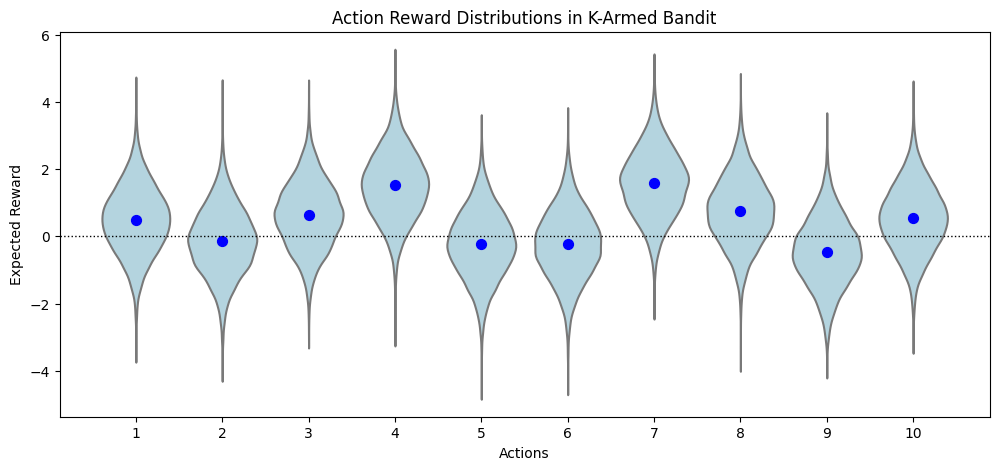

In [6]:
# Create a 10-armed bandit
bandit = KArmedBandit(K=10)

# Plot the full action reward distributions
plot_bandit_distributions(bandit)

In [7]:
# DO NOT MODIFY THIS CELL
def simulate(strategies, K, bandit_mean = 0, bandit_std = 1,runs=2000, n_steps=1000):
    """
    Simulates the K-armed bandit problem with different strategies.

    Parameters:
    - strategies (list): A list of strategies to evaluate.
    - K (int): Number of arms.
    - runs (int): Number of independent runs.
    - n_steps (int): Number of time steps per run.

    Returns:
    - mean_rewards (np.array): Average rewards per time step for each strategy.
    - mean_best_action_choices (np.array): Average probability of selecting the best action.
    """
    rewards = np.zeros((len(strategies), runs, n_steps))
    best_action_choices = np.zeros(rewards.shape)

    for i, strategy in enumerate(strategies):
        print(f"Evaluating strategy {i + 1}/{len(strategies)}...")

        for r in trange(runs):
            # Initialize a new K-armed bandit instance
            bandit = KArmedBandit(K, mean=bandit_mean, std_dev=bandit_std)
            best_action = bandit.get_optimal_action()  # Get the best possible action

            strategy.reset()  # Reset strategy state

            for t in range(n_steps):
                action = strategy.act()  # Strategy selects an action
                reward = bandit.get_reward(action)  # Bandit returns a reward
                
                rewards[i, r, t] = reward
                strategy.update(action, reward)  # Update strategy

                if action == best_action:
                    best_action_choices[i, r, t] = 1  # Track if best action was chosen

            time.sleep(0.00001)  # For tqdm (progress bar smoothness)

    # Compute mean rewards and best action selection frequency
    mean_rewards = rewards.mean(axis=1)
    mean_best_action_choices = best_action_choices.mean(axis=1)

    return mean_rewards, mean_best_action_choices

To examine the results a plot function is defined.

### Bandit Ground Truth

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/bandit_gt.png" width="900"/>


### Bandit Training GIF

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/bandit_training.gif" width="900"/>


In [8]:
# DO NOT MODIFY THIS CELL

def plotResults(strategies, rewards, best_action_choices):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

  for strategy, reward in zip(strategies, rewards):
      ax1.plot(reward, label=f"{strategy.name}", zorder=2)
  ax1.set_xlabel('Steps')
  ax1.set_ylabel('Average reward')
  ax1.grid(alpha=0.8, linestyle=':', zorder=0)
  ax1.set_title('Average reward of strategies')
  ax1.legend()

  for strategy, choices in zip(strategies, best_action_choices):
      ax2.plot(choices, label=f"{strategy.name}")
  ax2.set_xlabel('Steps')
  ax2.set_ylabel('% Optimal action')
  ax2.grid(alpha=0.8, linestyle=':', zorder=0)
  ax2.set_title('% Optimal action choices of strategies')
  ax2.legend()

  plt.show()

### Epsilon-Greedy Action Selection

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/e_greedy_action_selection.png" width="900"/>


## $\varepsilon$-greedy Action Selection

With this method, the agent will select a random action with an $\varepsilon$ probability ($0 \le \varepsilon \le 1$), and act greedily (select the best action according to its knowledge) otherwise. The action values are calculated using the *sample-averages* method: the value of an action is the average of all the rewards received after taking that action.



<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/epsilon_greedy.png" width="700"/>

*Pseudocode from page 32 of the Sutton & Barto book*




### Epsilon-Greedy Action Selection 2

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/e_greedy_action_selection_2.png" width="900"/>


In [9]:


class EpsilonGreedy(Strategy):
    def __init__(self, k, epsilon=0, initial=0,step_size=None):
        """
        Initializes the epsilon-greedy strategy.

        Parameters:
        - k (int): Number of actions (arms).
        - epsilon (float): Probability of exploring a random action.
        - initial (float): Initial value for action-value estimates.
        """
        super().__init__(k)  # Initialize parent Strategy class
        self.epsilon = epsilon  # Probability of exploration (random action selection)
        self.initial = initial  # Initial estimate for action values
        self.step_size = step_size
        self.q_estimations = np.zeros(self.k) + self.initial  # Estimated values of each action
        self.selections = np.zeros(self.k)  # Number of times each action is selected
        self.indices = np.arange(self.k)  # List of possible action indices

    @property
    def name(self):
        """
        Returns a formatted string representing the strategy name.
        """
        name_str = "Greedy" if self.epsilon == 0 else f"$\\varepsilon$-greedy, $\\varepsilon = {self.epsilon}$"
        if self.initial != 0:
            name_str += f", init: {self.initial}"  # Include initial value if non-zero
        return name_str

    def act(self):
        """
        Selects an action based on the epsilon-greedy policy.

        Returns:
        - (int) Index of the selected action.
        """
        if np.random.rand() < self.epsilon:  # With probability epsilon, explore
            return np.random.choice(self.indices)
        else:  # Otherwise, exploit (choose the best known action)
            return np.argmax(self.q_estimations)  

    def update(self, action, reward):
        """
        Updates the action-value estimate using sample averaging.

        Parameters:
        - action (int): Index of the chosen action.
        - reward (float): Reward received from the environment.
        """
        super().update(action, reward)  # Call parent class update method if needed
        self.selections[action] += 1  # Increment action selection count
        # Update the action-value estimate using incremental mean formula
        step_size = 1/self.selections[action] if not self.step_size else self.step_size # Step size 1/N for sample averaging by default
        self.q_estimations[action] +=  step_size * (reward - self.q_estimations[action])

    def reset(self):
        """
        Resets the internal state of the strategy for a new experiment.
        """
        super().reset()  # Call parent class reset method if needed
        self.q_estimations = np.zeros(self.k) + self.initial  # Reset action-value estimates
        self.selections = np.zeros(self.k)  # Reset action selection counts

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def plot_and_save(strategy, step,save_path = "assets/bandit_training.png"):
    """
    Creates and updates the figure, then saves it to disk.

    Parameters:
    - strategy (EpsilonGreedy): The current strategy with reward history.
    - step (int): Current training step.
    """
    K = strategy.k

    # Create new figure inside the function
    fig, ax = plt.subplots(figsize=(12, 5))

    # Prepare data
    reward_data = []
    action_labels = []

    for action, reward_list in strategy.rewards_history.items():
        reward_data.extend(reward_list)
        action_labels.extend([action+1] * len(reward_list))

    # Create violin plot
    sns.violinplot(x=action_labels, y=reward_data, inner=None, density_norm="width", color="lightcoral", linewidth=1.5, ax=ax)

    # Scatter plot for estimated means
    ax.scatter(range(K), strategy.q_estimations, color='red', s=50, zorder=3, label="Estimated Means")

    ax.axhline(0, linestyle='dotted', color='black', linewidth=1)
    ax.set_xlabel("Actions")
    ax.set_ylabel("Estimated Reward")
    ax.set_title(f"Training Step: {step} - Estimated Reward Distributions")
    ax.legend(["Estimated Means"])

    # Save the figure to the same file (overwrite each time)
    fig.savefig(save_path, format="png", dpi=150)
    plt.close(fig)  # Close figure to free memory

### UCB Action Selection

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/ucb_action_selection.png" width="900"/>


Visualize, how the $\varepsilon$-greedy Action Selection updates it's estimations of the reward distributions of the K-Armed bandit problem.

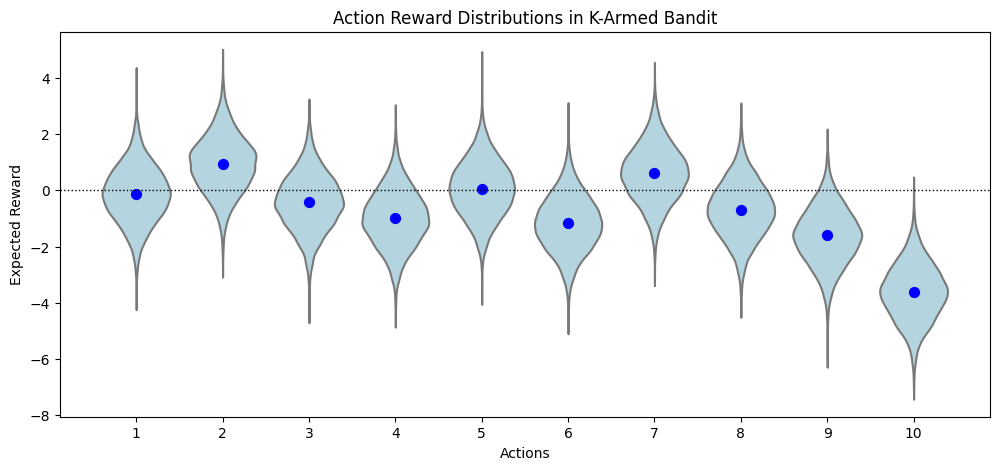

Saved GIF to: assets/bandit_training.gif


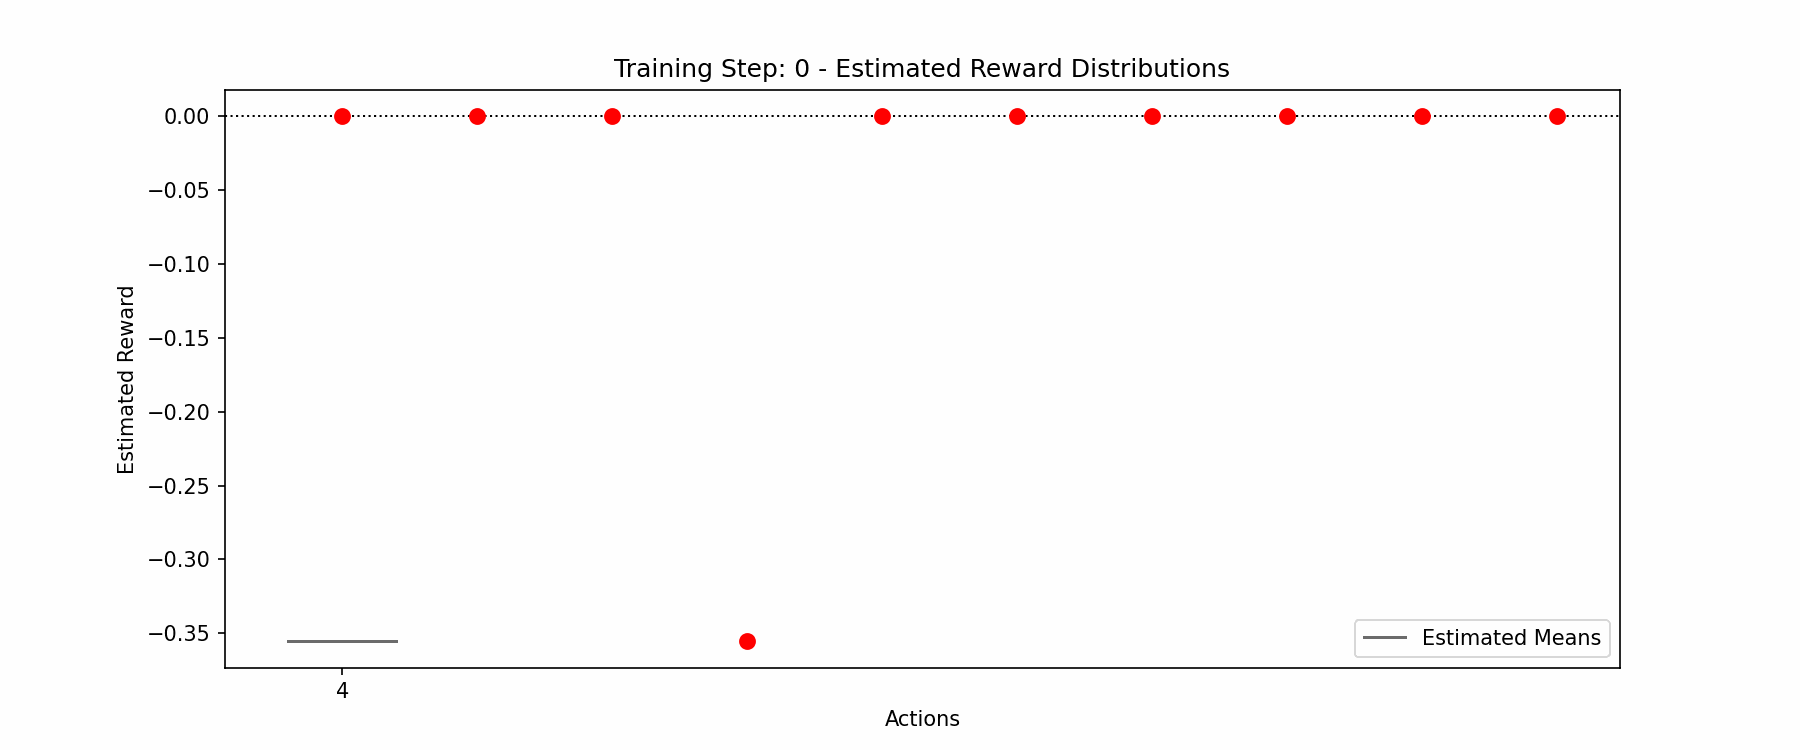

In [11]:
# Initialize bandit and strategy
from pathlib import Path
from PIL import Image
from IPython.display import Image as IPyImage, display

K = 10  # Number of arms
bandit = KArmedBandit(K)
strategy = EpsilonGreedy(k=K, epsilon=0.2)

# Training loop with in-memory frame capture for GIF export
n_steps = 5000
plot_interval = n_steps // 50

# Plot initial bandit distributions before training
plot_bandit_distributions(bandit)

tmp_frame = Path("assets/.tmp_bandit_frame.png")
frames = []

for step in range(n_steps + 1):
    action = strategy.act()
    reward = bandit.get_reward(action)
    strategy.update(action, reward)

    if step % plot_interval == 0:
        plot_and_save(strategy, step, save_path=str(tmp_frame))
        frames.append(Image.open(tmp_frame).copy())

# Build GIF from captured frames (for website use)
gif_path = Path("assets/bandit_training.gif")
if frames:
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=120,
        loop=0,
    )

for fr in frames:
    fr.close()

tmp_frame.unlink(missing_ok=True)

print(f"Saved GIF to: {gif_path}")
display(IPyImage(filename=str(gif_path)))


### Gradient Action Selection

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/gradient_action_selection.png" width="900"/>


Test of $\varepsilon$-greedy Action Selection.

### Gradient Action Selection 2

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/gradient_action_selection_2.png" width="900"/>


Evaluating strategy 1/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 2/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 3/3...


  0%|          | 0/200 [00:00<?, ?it/s]

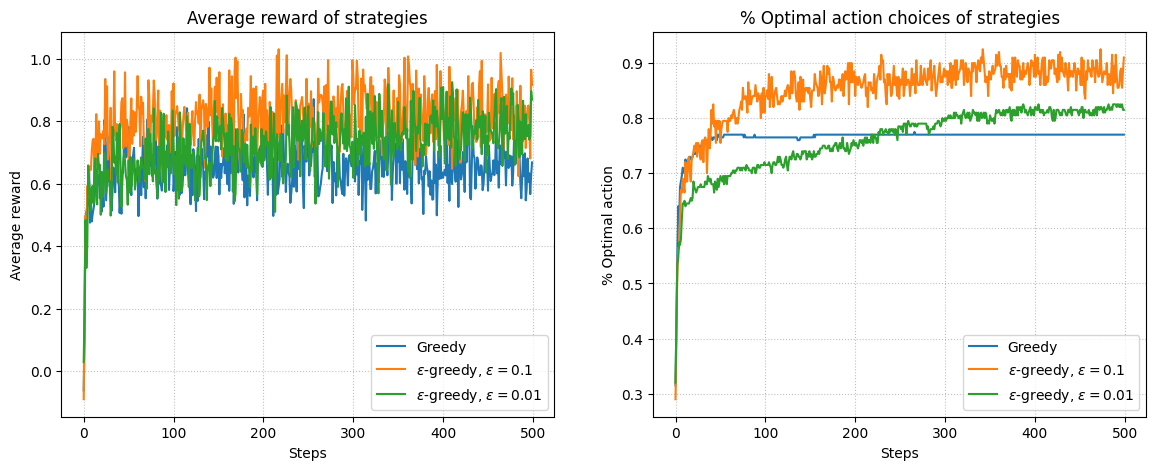

In [12]:
K = 3  # Number of actions

# List of strategies to test
strategies = [EpsilonGreedy(K,epsilon=0.0), 
              EpsilonGreedy(K, epsilon=0.1), 
              EpsilonGreedy(K, epsilon=0.01)]

# Evaluate strategies
rewards, best_action_choices = simulate(strategies, K=K, runs=200, n_steps=500)

plotResults(strategies, rewards, best_action_choices)

### Total Comparison

<img src="https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/sessions/session_01_k_armed_bandit/assets/total_comparison.png" width="900"/>


Evaluating strategy 1/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 2/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 3/3...


  0%|          | 0/200 [00:00<?, ?it/s]

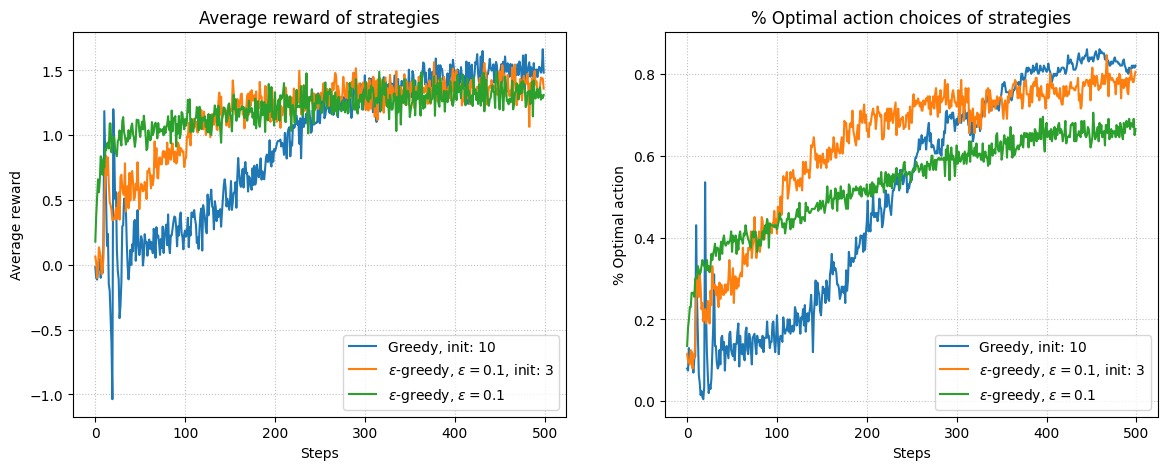

In [13]:
K = 10  # Number of actions

# List of strategies to test
strategies = [EpsilonGreedy(K,epsilon=0.0, initial=10,step_size=0.1), 
              EpsilonGreedy(K, epsilon=0.1,initial=3,step_size=0.1), 
              EpsilonGreedy(K, epsilon=0.1, initial=0,step_size=0.1)]

# Evaluate strategies
rewards, best_action_choices = simulate(strategies, K=K, runs=200, n_steps=500)

plotResults(strategies, rewards, best_action_choices)

## Upper-Confidence-Bound (UCB) Action Selection

The UCB action selection method offers a way to select an action by taking both the estimated value, as well as the accuracy of those estimates into account.
It uses the following formula:

$$ A_t := \underset{a}{\arg\max} \left[ Q_t(a) + c \sqrt{\frac{\ln(t)}{N_t(a)}} \right] $$

Where $Q_t(a)$ denotes the value of action $a$ (calculated using the *sample-averages* method), $N_t(a)$ denotes the number of times that action $a$ has
been selected prior to time $t$, and the number $c > 0$ controls
the degree of exploration. If $N_t(a) = 0$, then $a$ is considered to be a maximizing action.




In [14]:
import numpy as np

class UCB(Strategy):
    """
    Implements the Upper Confidence Bound (UCB) action selection strategy.
    This method balances exploration and exploitation by selecting actions 
    with the highest estimated value plus an uncertainty bonus.
    """

    def __init__(self, k, c=1, initial=0, step_size=None):
        """
        Initializes the UCB strategy.

        Parameters:
        - k (int): Number of actions (arms).
        - c (float): Exploration degree (higher c encourages more exploration).
        - initial (float): Initial estimate for action values.
        """
        super().__init__(k)  # Initialize parent Strategy class
        self.c = c  # Degree of exploration (controls uncertainty bonus)
        self.initial = initial  # Initial action-value estimates
        self.step_size = step_size
        self.q_estimations = np.zeros(self.k) + self.initial  # Estimated action values
        self.selections = np.zeros(self.k)  # Number of times each action was selected
        self.t = 0  # Time step counter

    @property
    def name(self):
        """
        Returns a formatted string representing the UCB strategy name.
        """
        return f"UCB, $c = {self.c}$"

    def act(self):
        """
        Selects an action using the UCB formula.

        Returns:
        - (int) Index of the selected action.
        """
        # Calculate the UCB upper confidence bound for each action:
        # UCB = Q(a) + c * sqrt( log(t) / N(a) )
        # - Q(a): Estimated value of action a
        # - c: Degree of exploration (hyperparameter)
        # - t: Current time step
        # - N(a): Number of times action a has been selected

        UCB_estimations = self.q_estimations + self.c * np.sqrt(
            np.log(self.t + 1) / (self.selections + 1e-5)
        )  # Small epsilon to avoid division by zero

        return np.argmax(UCB_estimations)  # Select the action with highest UCB value

    def update(self, action, reward):
        """
        Updates action value estimates using sample averaging.

        Parameters:
        - action (int): Index of the chosen action.
        - reward (float): Reward received from the environment.
        """
        super().update(action, reward)
        self.t += 1  # Increment time step
        self.selections[action] += 1  # Increment selection count for the action
        
        
        # Update the estimated action value using incremental mean:
        # Q(a) = Q(a) + (1/N(a)) * (R - Q(a))
        step_size = 1/self.selections[action] if not self.step_size else self.step_size # Step size 1/N for sample averaging by default
        self.q_estimations[action] += step_size * (reward - self.q_estimations[action])

    def reset(self):
        """
        Resets the internal state of the UCB strategy for a new experiment.
        """
        super().reset()
        self.t = 0  # Reset time step counter
        self.q_estimations = np.zeros(self.k) + self.initial  # Reset action-value estimates
        self.selections = np.zeros(self.k)  # Reset action selection counts

Test of UCB.

Evaluating strategy 1/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 2/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 3/3...


  0%|          | 0/200 [00:00<?, ?it/s]

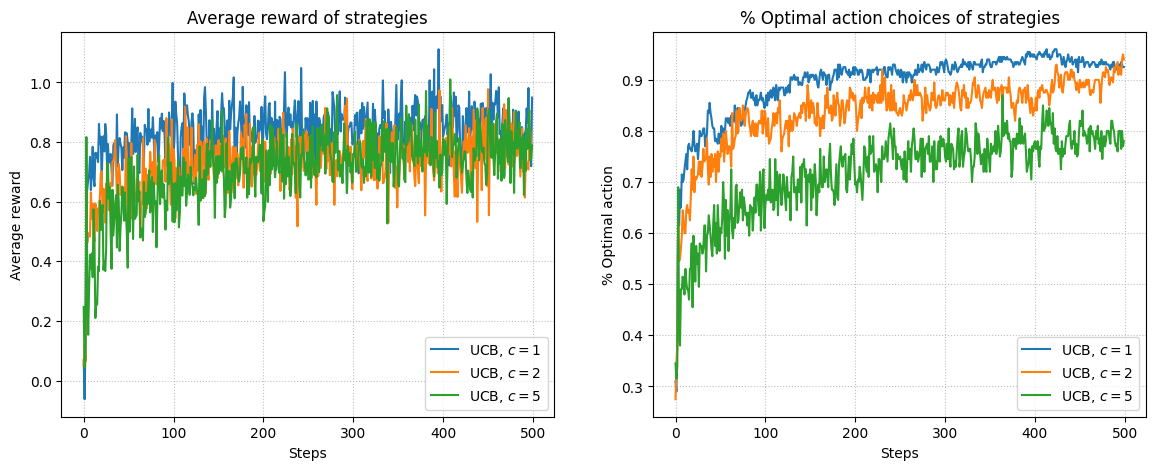

In [15]:
K = 3  # Number of actions

# List of strategies to test
strategies = [UCB(K),
              UCB(K, c=2),
              UCB(K, c=5)]

# Evaluate strategies
rewards, best_action_choices = simulate(strategies, K=K, runs=200, n_steps=500)

plotResults(strategies, rewards, best_action_choices)

## Gradient Bandit Algorithms

Instead of estimating action values, this method learns a numerical *preference*, denoted $H_t(a)$ for each action. The larger the preference, the more often that action is taken, but the preference has no interpretation in terms of reward. Action probabilites are determined using the *soft-max* function:

$$ \pi_t(a) := \Pr\{A_t = a\} := \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} $$

Here we have also introduced a useful new notation, $\pi_t(a)$, for the probability of
taking action $a$ at time $t$. Note that this function defines a probability distribution over the set of all actions. On each step, after selecting action $A_t$ and receiving the reward $R_t$, the
action preferences are updated by:

$$ H_{t+1}(a) := H_t(a) + \alpha(R_t - \bar{R}_t)(\mathbb{1}_{a=A_t} - \pi_t(a)) $$

Where $\alpha > 0$ is a step-size parameter, and $\bar{R}_t \in \mathbb{R}$ is the average of all the rewards up
through and including time $t$. 
The $\bar{R}_t$ term serves as a
baseline with which the reward is compared.



In [16]:
import numpy as np

class Gradient(Strategy):
    """
    Implements the Gradient Bandit Algorithm.
    This method uses policy gradient updates to optimize action selection.
    """

    def __init__(self, k,step_size=0.1, use_baseline = True):
        """
        Initializes the Gradient Bandit strategy.

        Parameters:
        - k (int): Number of actions (arms).
        - alpha (float): Step-size parameter for updating action preferences.
        """
        super().__init__(k)  # Initialize parent Strategy class
        self.alpha = step_size  # Step-size parameter (learning rate)
        self.preferences = np.zeros(self.k)  # Action preference values (H(a))
        self.indices = np.arange(self.k)  # List of possible action indices
        self.baseline = 0  # Average reward (used as a baseline)
        self.use_baseline = use_baseline
        self.t = 0  # Time step counter

    @property
    def name(self):
        """
        Returns a formatted string representing the strategy name.
        """
        return f"Gradient, $\\alpha = {self.alpha}$" if self.use_baseline else f"Gradient, $\\alpha = {self.alpha}$, No Baseline"

    def act(self):
        """
        Selects an action based on the softmax probabilities.

        Returns:
        - (int) Index of the selected action.
        """
        # Compute softmax probabilities for all actions
        action_probabilities = self.softmax(self.preferences)
        
        # Select an action according to the softmax distribution
        return np.random.choice(self.indices, p=action_probabilities)

    def update(self, action, reward):
        """
        Updates action preferences using policy gradient.

        Parameters:
        - action (int): Index of the chosen action.
        - reward (float): Reward received from the environment.
        """
        super().update(action, reward)  # Call parent class update method if needed
        self.t += 1  # Increment time step

        # Update the baseline reward using an incremental mean
        if self.use_baseline:
            self.baseline += (reward - self.baseline) / self.t

        # Create a one-hot vector indicating the chosen action
        one_hot = np.zeros(self.k)
        one_hot[action] = 1

        # Update action preferences using gradient ascent
        # H(a) = H(a) + α * (R - baseline) * (I(a) - π(a))
        self.preferences += self.alpha * (reward - self.baseline) * (one_hot - self.softmax(self.preferences))

    def reset(self):
        """
        Resets the internal state of the Gradient Bandit strategy.
        """
        super().reset()
        self.t = 0  # Reset time step counter
        self.baseline = 0  # Reset baseline reward estimate
        self.preferences = np.zeros(self.k)  # Reset action preferences

    def softmax(self, x):
        """
        Computes the softmax probability distribution.

        Parameters:
        - x (np.array): Input preferences.

        Returns:
        - (np.array): Probability distribution over actions.
        """
        exp_x = np.exp(x - np.max(x))  # Numerical stability trick
        return exp_x / np.sum(exp_x)

Test of Gradient Bandit Algorithm.

Evaluating strategy 1/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 2/3...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 3/3...


  0%|          | 0/200 [00:00<?, ?it/s]

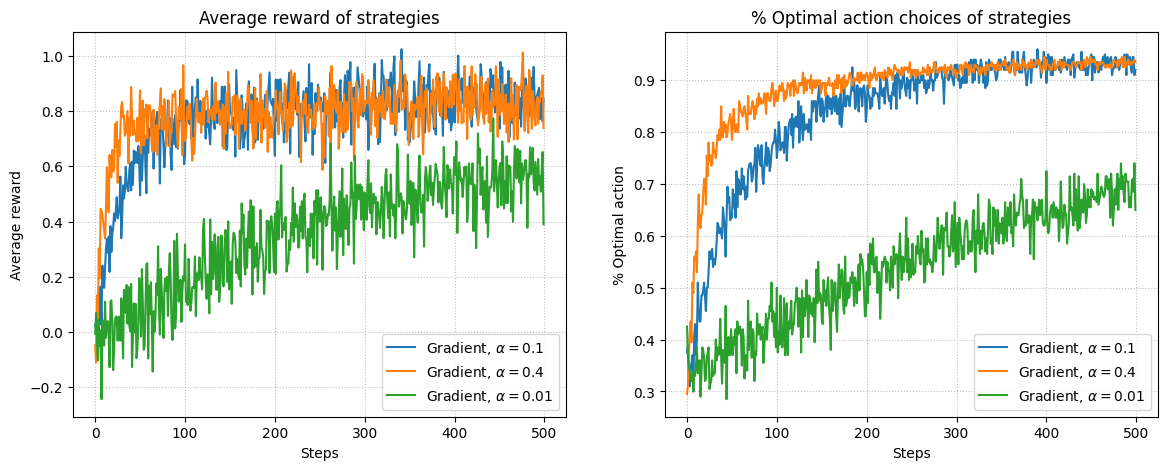

In [17]:
K = 3  # Number of actions

# List of strategies to test
strategies = [Gradient(K,step_size=0.1),
              Gradient(K, step_size=0.4),
              Gradient(K, step_size=0.01)]

# Evaluate strategies
rewards, best_action_choices = simulate(strategies, K=K, runs=200, n_steps=500)

plotResults(strategies, rewards, best_action_choices)

Evaluating strategy 1/2...


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating strategy 2/2...


  0%|          | 0/200 [00:00<?, ?it/s]

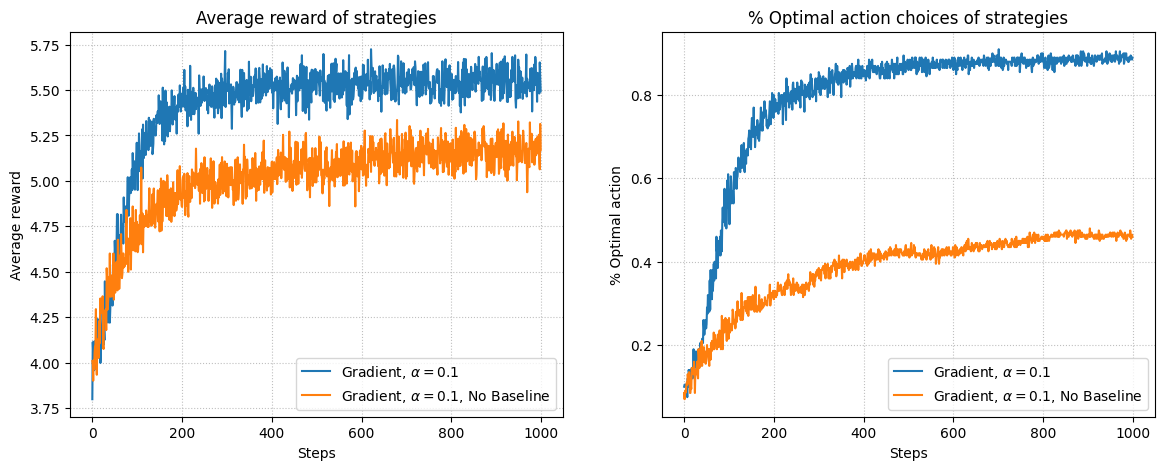

In [18]:
K = 10  # Number of actions

# List of strategies to test
strategies = [Gradient(K,step_size=0.1),
             #Gradient(K, step_size=0.4),
              Gradient(K, step_size=0.1, use_baseline=False),
             #Gradient(K, step_size=0.4, use_baseline=False)
             ]

# Evaluate strategies
rewards, best_action_choices = simulate(strategies, K=K,bandit_mean=4, runs=200, n_steps=1000)

plotResults(strategies, rewards, best_action_choices)

## Comprehensive test

In this final section let's run a longer comprehensive test with more actions.

Evaluating strategy 1/4...


  0%|          | 0/2000 [00:00<?, ?it/s]

Evaluating strategy 2/4...


  0%|          | 0/2000 [00:00<?, ?it/s]

Evaluating strategy 3/4...


  0%|          | 0/2000 [00:00<?, ?it/s]

Evaluating strategy 4/4...


  0%|          | 0/2000 [00:00<?, ?it/s]

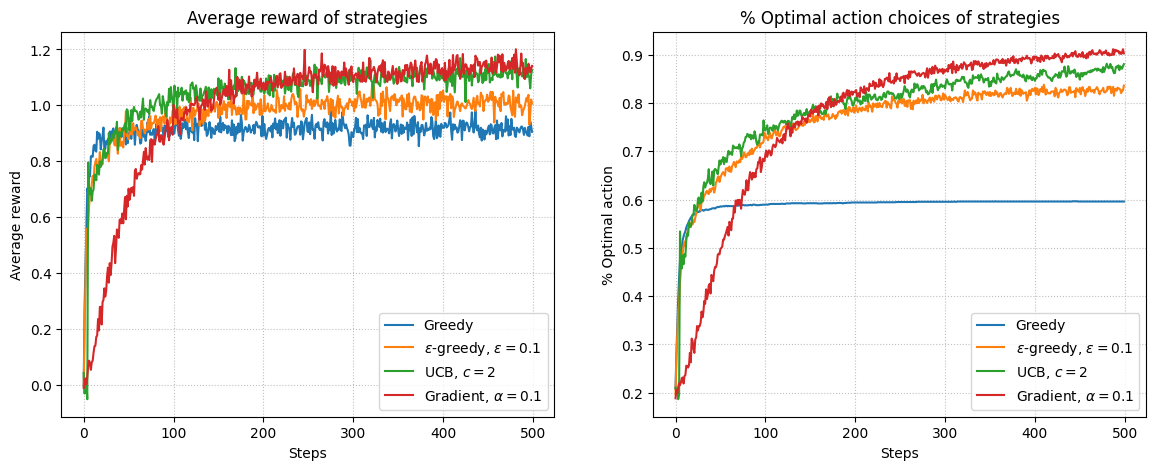

In [19]:
K = 5  # Number of actions

# List of strategies to test
strategies = [
        EpsilonGreedy(K),
        EpsilonGreedy(K, epsilon=0.1),
        UCB(K, c=2),
        Gradient(K)
    ]

# Evaluate strategies
rewards, best_action_choices = simulate(strategies, K=K, runs=2000, n_steps=500)

plotResults(strategies, rewards, best_action_choices)

# References

- Inspiration from: <https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter02/ten_armed_testbed.py>
